<a href="https://colab.research.google.com/github/tedlc/AISTATS23/blob/main/DCCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchsummary
!pip install cca-zoo[deep]
!pip install multiviewdata
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import itertools
from matplotlib import image
import glob as glob
from PIL import Image
import cca_zoo

from multiviewdata.torchdatasets import SplitMNIST, NoisyMNIST
from torch.utils.data import Subset
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("Using the GPU!")
else:
  print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 2.4 MB/s 
     |████████████████████████████████| 2.1 MB 20.1 MB/s 
     |████████████████████████████████| 198 kB 17.7 MB/s 
     |████████████████████████████████| 798 kB 56.7 MB/s 
     |████████████████████████████████| 529 kB 49.8 MB/s 
     |████████████████████████████████| 87 kB 6.1 MB/s 
     |████████████████████████████████| 154 kB 51.2 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115940 sha256=76fde536d90bcb0bdffc5fb28507e0978c58730da31b74e0ee4bb805b8bb6746
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
PyTorch Version:  1

In [2]:
def get_dataloaders(
        dataset,
        val_dataset=None,
        batch_size=None,
        val_batch_size=None,
        drop_last=True,
        val_drop_last=False,
        shuffle_train=False,
        pin_memory=True,
        num_workers=0,
        persistent_workers=True,
):
    """
    A utility function to allow users to quickly get hold of the dataloaders required by pytorch lightning
    :param dataset: A CCA dataset used for training
    :param val_dataset: An optional CCA dataset used for validation
    :param batch_size: batch size of train loader
    :param val_batch_size: batch size of val loader
    :param num_workers: number of workers used
    :param pin_memory: pin memory used by pytorch - True tends to speed up training
    :param shuffle_train: whether to shuffle training data
    :param val_drop_last: whether to drop the last incomplete batch from the validation data
    :param drop_last: whether to drop the last incomplete batch from the train data
    :param persistent_workers: whether to keep workers alive after dataloader is destroyed
    """
    if num_workers == 0:
        persistent_workers = False
    if batch_size is None:
        batch_size = len(dataset)
    train_dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=shuffle_train,
        persistent_workers=persistent_workers,
    )
    if val_dataset:
        if val_batch_size is None:
            val_batch_size = len(val_dataset)
        val_dataloader = DataLoader(
            val_dataset,
            batch_size=val_batch_size,
            drop_last=val_drop_last,
            num_workers=num_workers,
            pin_memory=pin_memory,
            persistent_workers=persistent_workers,
        )
        return train_dataloader, val_dataloader
    return train_dataloader

In [3]:
from multiviewdata.torchdatasets import SplitMNIST, NoisyMNIST
from torch.utils.data import Subset
import numpy as np

from cca_zoo.data.deep import get_dataloaders


def example_mnist_data(n_train, n_val, batch_size=50, val_batch_size=10, type="split"):
    if type == "split":
        train_dataset = SplitMNIST(
            root="", mnist_type="MNIST", train=True, download=True
        )
    else:
        train_dataset = NoisyMNIST(
            root="", mnist_type="MNIST", train=True, download=True
        )

    # Adding noise to the mnist
    for i in train_dataset:
      noise = np.random.normal(0.0, 0.1, i['views'][1].shape)
      noise = torch.from_numpy(noise)
      noisy_view=list(i['views'])
      noisy_view[1]+=noise
      i['views']=noisy_view

    val_dataset = Subset(train_dataset, np.arange(n_train, n_train + n_val))
    train_dataset = Subset(train_dataset, np.arange(n_train))
    train_loader, val_loader = get_dataloaders(
        train_dataset, val_dataset, batch_size=batch_size, val_batch_size=val_batch_size
    )
    train_labels = train_loader.collate_fn(
        [train_dataset.dataset[idx]["label"] for idx in train_dataset.indices]
    ).numpy()
    return train_loader, val_loader, train_labels

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/setup.py:178: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params
----------------------------------------
0 | encoders | ModuleList | 101 K 
----------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.404     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


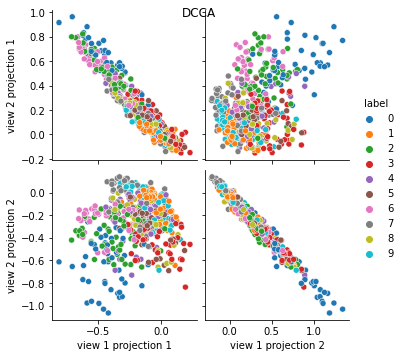

Sanity Checking: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/setup.py:178: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type       | Params
----------------------------------------------
0 | encoders       | ModuleList | 101 K 
1 | decoders       | ModuleList | 101 K 
2 | latent_dropout | Dropout    | 0     
----------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.812     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


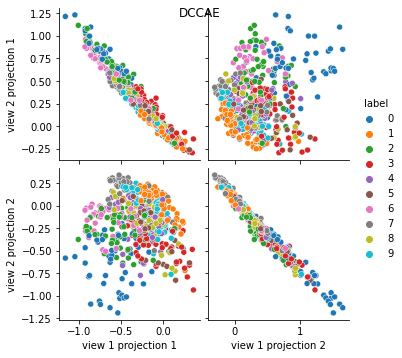

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/setup.py:178: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params
----------------------------------------
0 | encoders | ModuleList | 101 K 
1 | bns      | ModuleList | 0     
----------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.404     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


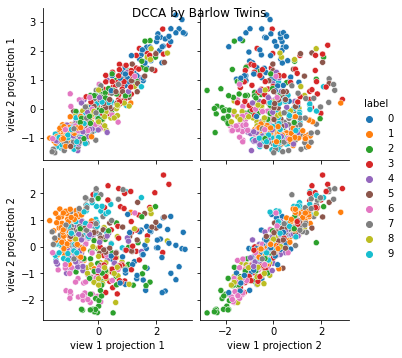

In [4]:
import pytorch_lightning as pl
from matplotlib import pyplot as plt

# %%
from cca_zoo.deepmodels import (
    DCCA,
    DCCA_NOI,
    DCCA_SDL,
    DCCAE,
    BarlowTwins,
)
from cca_zoo.deepmodels import architectures
from cca_zoo.plotting import pairplot_label


# %%
# Data
# -----
LATENT_DIMS = 2
EPOCHS = 10
N_TRAIN = 500
N_VAL = 100

normal_train_loader, normal_val_loader, normal_train_labels = example_mnist_data(N_TRAIN, N_VAL)
#noisy_train_loader, noisy_val_loader, noisy_train_labels = example_mnist_data(N_TRAIN, N_VAL, type="noisy")
encoder_1 = architectures.Encoder(latent_dims=LATENT_DIMS, feature_size=392)
encoder_2 = architectures.Encoder(latent_dims=LATENT_DIMS, feature_size=392)
decoder_1 = architectures.Decoder(latent_dims=LATENT_DIMS, feature_size=392)
decoder_2 = architectures.Decoder(latent_dims=LATENT_DIMS, feature_size=392)



# %%
# Deep CCA
# ----------------------------
dcca = DCCA(latent_dims=LATENT_DIMS, encoders=[encoder_1, encoder_2])
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    enable_checkpointing=False,
    log_every_n_steps=1,
)

trainer.fit(dcca, normal_train_loader, normal_val_loader)
dcca_multiview_result = dcca.transform(normal_train_loader)
pairplot_label(dcca_multiview_result, normal_train_labels, title="DCCA")
plt.show()



# %%
# Deep CCAE
# ----------------------------
dccae = DCCAE(latent_dims=LATENT_DIMS, encoders=[encoder_1, encoder_2],decoders=[decoder_1,decoder_2])
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    enable_checkpointing=False,
    log_every_n_steps=1,
)

trainer.fit(dccae, normal_train_loader, normal_val_loader)
dccae_multiview_result=dccae.transform(normal_train_loader)
pairplot_label(dccae_multiview_result, normal_train_labels, title="DCCAE")

plt.show()

# %%
# Deep CCA by Barlow Twins
# ----------------------------------------------
barlowtwins = BarlowTwins(latent_dims=LATENT_DIMS, encoders=[encoder_1, encoder_2])
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    enable_checkpointing=False,
    log_every_n_steps=1,
)
trainer.fit(barlowtwins, normal_train_loader, normal_val_loader)
pairplot_label(
    barlowtwins.transform(normal_train_loader), normal_train_labels, title="DCCA by Barlow Twins"
)
plt.show()

In [ ]:
from cca_zoo.data.simulated import LinearSimulatedData
from sklearn.model_selection import train_test_split
from cca_zoo.plotting import pairplot_train_test
from cca_zoo import CCA
# Data
# ------
# np.random.seed(42)
# n = 200
# p = 25
# q = 25
# latent_dims = 3

# (X, Y) = LinearSimulatedData(
#     view_features=[p, q], latent_dims=latent_dims, correlation=[0.9, 0.8, 0.7]
# ).sample(n)

# X_tr, X_te, Y_tr, Y_te = train_test_split(X, Y, test_size=0.2, random_state=42)
# print(X.shape)
# %%
# Model
# ------
latent_dims = 2

train_list = []
X,Y=[],[]
for i in normal_train_loader:
  for j in i['views'][0]:
    X.append(j.numpy())
  for j in i['views'][1]:
    Y.append(j.numpy())
X,Y = np.array(X), np.array(Y)

cca = CCA(latent_dims=latent_dims).fit((X, Y))
cca_result = cca.transform((X, Y))


#%%
# Plotting
# ---------
# print(cca.transform((X_te, Y_te))[0].shape)
# pairplot_train_test(cca.transform((X_tr, Y_tr)), cca.transform((X_te, Y_te)))
# plt.show()

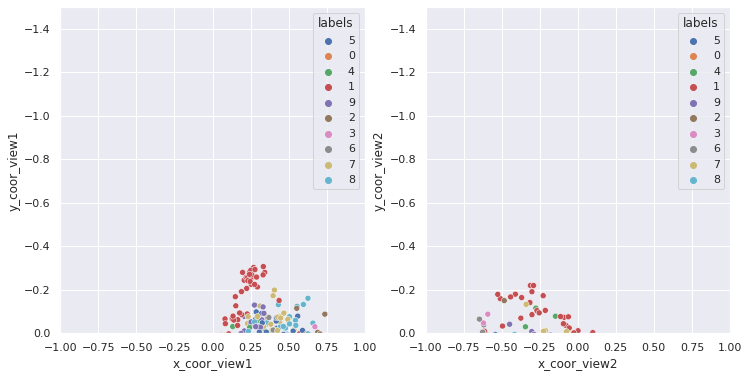

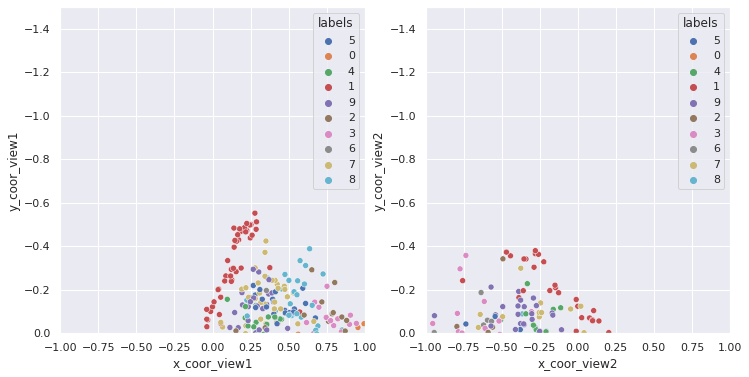

In [ ]:
# Plotting Module
import seaborn as sns
import pandas as pd

def plotting(view_1, view_2, labels):
  # view 1
  view_dict = {"x_coor_view1":[], "y_coor_view1":[],"x_coor_view2":[], "y_coor_view2":[], "labels":[]}
  for point1, point2, label in zip(view_1, view_2, labels):
    view_dict["x_coor_view1"].append(point1[0])
    view_dict["y_coor_view1"].append(point1[1])
    view_dict["x_coor_view2"].append(point2[0])
    view_dict["y_coor_view2"].append(point2[1])
    view_dict["labels"].append(str(label))
  view_df = pd.DataFrame(view_dict)
  sns.set(rc={'figure.figsize':(12,6)})

  #subplot
  f, axes = plt.subplots(1, 2)
  axes[0].set_xlim(-1.0, 1,0)
  axes[0].set_ylim(0, -1.5)
  axes[1].set_xlim(-1.0, 1.0)
  axes[1].set_ylim(0, -1.5)
  sns.scatterplot(data=view_df, x="x_coor_view1", y="y_coor_view1", hue="labels", legend="full", ax=axes[0])
  sns.scatterplot(data=view_df, x="x_coor_view2", y="y_coor_view2", hue="labels", legend="full", ax=axes[1])

view_11, view_12 = dcca_multiview_result[0], dcca_multiview_result[1]
view_21, view_22 = dccae_multiview_result[0], dccae_multiview_result[1]
plotting(view_11, view_12, normal_train_labels)
plotting(view_21, view_22, normal_train_labels)


In [ ]:
# calculating error rate for MNIST

# training SVM
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
linear_svc = svm.LinearSVC()
linear_svc.fit(dcca_multiview_result[:][0][:], normal_train_labels)
#linear_svc.decision_function(dcca_multiview_result[:][0][:])

kfold=KFold(n_splits=10, shuffle=True, random_state=0)
# Simple CCA Score
simple_cca_svc = svm.LinearSVC()
simple_score = cross_val_score(linear_svc, cca_result[:][0][:], normal_train_labels , cv=kfold)
print(sum(simple_score)/10)

# DCCA score
linear_svc = svm.LinearSVC()
linear_scores = cross_val_score(linear_svc,dcca_multiview_result[:][0][:], normal_train_labels , cv=kfold)
print(sum(linear_scores)/10)

# DCCAE score
linear_svc_dccae = svm.LinearSVC()
linear_svc_dccae.fit(dccae_multiview_result[:][0][:], normal_train_labels)
dccae_score = cross_val_score(linear_svc,dccae_multiview_result[:][0][:], normal_train_labels , cv=kfold)
print(sum(dccae_score)/10)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

0.238
0.35000000000000003
0.37799999999999995


In [ ]:
# Dataloader
from torchvision import datasets, transforms
import torch

def load_data(data_folder, batch_size, train, num_workers=0, **kwargs):
    transform = {
        'train': transforms.Compose(
            [transforms.Resize([256, 256]),
                transforms.RandomCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])]),
        'test': transforms.Compose(
            [transforms.Resize([224, 224]),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])])
    }
    data = datasets.ImageFolder(root=data_folder, transform=transform['train' if train else 'test'])
    data_loader = get_data_loader(data, batch_size=batch_size, 
                                shuffle=True if train else False, 
                                num_workers=num_workers, **kwargs, drop_last=True if train else False)
    n_class = len(data.classes)

    return data_loader, n_class

def get_data_loader(dataset, batch_size, shuffle=True, drop_last=False, num_workers=0, infinite_data_loader=False, **kwargs):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=drop_last, num_workers=num_workers, **kwargs)




In [ ]:
# Hazy Image Data
from google.colab import drive
drive.mount('/content/drive')
# Loading Haze Image Dataset
train_loader, n_class = load_data('/content/drive/MyDrive/haze_dataset/ImageNet-18', batch_size=32, train=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_features, train_labels = next(iter(train_loader))
print(train_labels)

tensor([14,  6, 12, 14,  8,  8,  7, 13,  0,  7,  3,  4,  3, 12,  3,  3,  4, 12,
         1, 17,  3, 10, 17, 11, 12,  2,  7,  4,  5, 14,  8, 11])


In [ ]:
# Haze Image Domain Adapataion

# %%
# Data
# -----
LATENT_DIMS = 2
EPOCHS = 10
N_TRAIN = 500
N_VAL = 100

#val_loader
haze_train_labels = []
haze_train_features = []
# for _ in range(len(train_loader)):
  
  # train_feature, train_label = next(iter(train_loader))
  # haze_train_labels.append(train_label)
  
for i in train_loader:
  haze_train_labels.append(i[1])
  haze_train_features.append(i[0])
encoder_1 = architectures.Encoder(latent_dims=LATENT_DIMS, feature_size=(256*256*3))
encoder_2 = architectures.Encoder(latent_dims=LATENT_DIMS, feature_size=(256*256*3))
decoder_1 = architectures.Decoder(latent_dims=LATENT_DIMS, feature_size=(256*256*3))
decoder_2 = architectures.Decoder(latent_dims=LATENT_DIMS, feature_size=(256*256*3))

KeyboardInterrupt: ignored